
# <span style="color:rgb(213,80,0)">A brief introduction to the dmrimatlab toolbox</span>
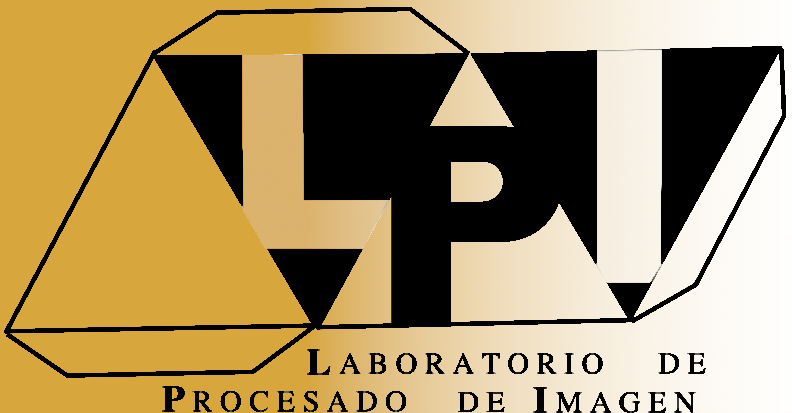(https://www.lpi.tel.uva.es/)

**DMRIMatlab** is the result of a long\-term effort to bring together the diffusion MRI analysis software tools that the Laboratory of Image Processing has been developing over the last decades. Of course, many of the classical methods such as DT\-MRI are also integrated, so the toolbox represents a trade\-off between state\-of\-the\-art and innovative methodologies. The leitmotiv of the software is robustness and computational efficiency, so that it can be used for the systematic processing of large databases for clinical studies.


The project is hosted in [\[github\]](https://github.com/atriveg/dmrimatlab), and regular updates are pushed with new functionalities and bug fixes. Please start by downloading the code from the github repo so we can get started.

## 1. Have you already donwloaded the code? Set\-up the toolbox
<p style="text-align:left">
   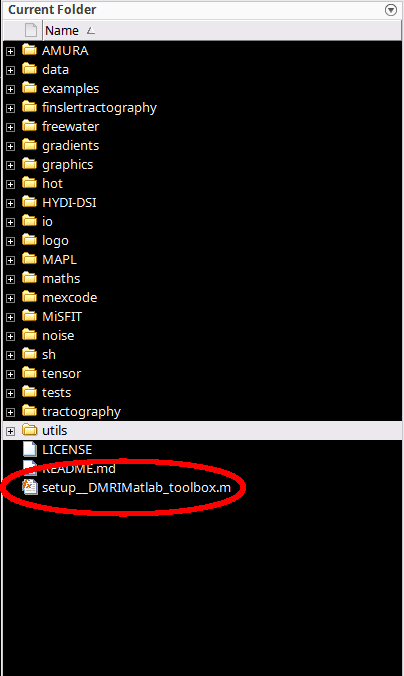
</p>


OK, first thing to do is "set up" the toolbox. From within the Octave interface, browse to the folder that you have just unzipped. An "m" file named setup\_\_DMRIMatlab\_toolbox.m should be there. You have to run this script by either right\-clicking the file and selecting Run or directly typing in the command line:

<pre>
>> setup__DMRIMatlab_toolbox
</pre>

The whole toolbox is command\-line oriented, so that the latter is the preferred way to work. Once you run this command, you will nottice that all sub\-folders become highlighted, meaning they have been added to Octave's path and you can use whatever command of the toolbox from wherever location in your computer.


Note this won't make any permanent change in your installation or configuration, and will only persist for your current session (meaning: you will have to re\-run the commmand each time you start Octave).


***TO DO:***


Runn this code snippet to set\-up the toolbox (*Ctrl+ENTER*)


In [ ]:
addpath('..'); % FIX THIS LINE!!!
setup__DMRIMatlab_toolbox; % Fix the proper paths for the toolbox

## 2. Download some test data

Throughout the demo we will need some test data (diffusion MRI volumes and the meta\-data required to interpret them) to illustrate the capabilities of the software. It is not directly included with the toolbox because diffusion MRI uses very large data sets that cannot fit Github's limitations. Don't worry, the toolbox itself has a download command that will connect to our servers, download the test data and put it in the proper place (if you are wondering, in a folder named "data" within the main folder of the toolbox:


***TO DO:***


Download test data from our servers. They are several hundreds of MB!!! (*Ctrl+ENTER*)


In [ ]:
download_dmritestdata;

## 3. Compile mex binaries

As we have said, DMRIMatlab pursues computational efficiency as a primary goal. If have ever used Python's dipy or MRTrix to process diffusion data, you do know that some processing tasks with diffusion MRI may become insanely heavy. Our toolbox outperforms both of them w.r.t. computational efficiently in most of these tasks (reaching one order of magnitude for some of them). How do we attain that? By combining several strategies:

-  Extensive use of image masking to avoid processing undesired voxels.
-  Vectorization of Matlab code, parallel for loops and "implicit expansions" (dimension broadcasting) to reduce memory requirements.
-  **When vectorization is not possible, optimized C++/mex implementations have been coded: we use threads with proceesing queues that keep all processors busy all the time.**
-  **Direct calls to BLAS/LAPACK libraries ensure maximum efficiency for algebraic operations.**
-  **Specific optimization routines, as opposed to general purpose ones, have been coded when needed.**

The last two points imply that you will need to compile some C++ code to get things working. Don't worry: the toolbox includes an automatic script that will do this for you but, before you can run this script, we have to make sure that you have the proper developer tools:


***TO DO:***


Check if you have a working C/C++ compiler that can be used with Matlab (*Ctrl+ENTER*)


In [ ]:
mex --print CC
mex --print CXX


If the previous commands are not able to find a proper compiler, you will need to install one: it suffices to install the latest gcc suite from your preferred software manager. Once you're done, restarting Octave should be enough to get things working.

So am I all done? Unfortunately, you're not. As opposed to Matlab, GNU Linux's Octave does not embed itself a particular implementation of BLAS, but instead it depends on that provided by the system (typically, Netlib's BLAS/LAPACK through arpack). For this reason, dmrimatlab offers several options for the mex code to be linked against. You can choose the one that best fits your needs by creating a file named 'config.octave' in the subfolder named 'mexcode'; otherwise, this file will be created from scratch the first time 'makefile_mexcode' is called. It should include variables definition like:

    BLAS_CONFIG=openblas-local

(or BLAS_CONFIG=netlib, BLAS_CONFIG=openblas or BLAS_CONFIG=mkl, see description below) to tell the actual version of BLAS to be used, one of:

[netlib] So that the system-provided implementation (Netlib's BLAS/LAPACK) will be used. NOTE: in this case you will have to manually install the C interfaces to BLAS/LAPACK, i.e. use your preferred software manager (pacman, apt, ...) to install:
   - cblas, which will provide /usr/include/cbas.h and /usr/lib/libcblas.so (or alike).
   - lapacke, which will provide /usr/include/lapacke.h and /usr/lib/liblapacke.so (or alike).
Note that Netlib's implementations are not the reference ones, since they are both little efficient and buggy (though we haven't found any bug-related problems with our software). For this reason, one might prefer to use:

[openblas] So that a system-wide implementation of OpenBLAS will be used. NOTE: in this case you will have to manually install the "openblas" package with your preferred software manager (pacman, apt, ...). It will provide:
   - /usr/include/openblas/cblas.h, /usr/include/openblas/lapacke.h, /usr/lib/libopenblas.so(or alike).
OpenBLAS is more efficient that Netlib's implementation. Besides, it has multi-threading capabilities. Unfortunately, this is a problem for our mex code, which is also multi-threaded. Though our code prevents thread spawning by calling "blas_set_num_threads()" as needed, problems can still arise in certain systems with a large number of cores. They can be fixed by running Octave as:

    $ OMP_NUM_THREADS=1 octave

so that OpenBLAS will always run single-thread. Note, however, that any other Octave-related software using Open MP will also run single-thread with this fix, which might impact its performance.

[openblas-local] This will automatically download the source code and compile a local OpenBLAS library without Open MP, so that it will be single-threaded in nature, without conflicting with any other existing libraries. This is the safest option; besides, it does not require manually installing any additional software. However, it is slightly more complex since it has to compile OpenBLAS (and it will take some more time); note that you will need gcc, g++ and gfortran. This is the default option. If used, you can set a variable in the config file:

    LOCAL_OPENBLAS_SUFFIX=suffix

and 'suffix' will be appended to the name of the local library (and the name of the local folder where it is built).

[mkl] In case you are using a x86_64 based processor, the by-far more efficient BLAS implementation is Intel's Oneapi MKL. Using this option is the only way to attain a similar performance as in the Matlab version of the toolbox. Note this requires using your preferred software manager (pacman, apt, ...) to install the package intel-oneapi-mkl (or alike). The installation root for this package will be something like "/opt/intel/oneapi/mkl/2025.0", where you should be able to find folders named "lib" and "include". This path must be provided in the config file by setting the variable:

    MKL_ROOT=/opt/intel/oneapi/mkl/2025.0


***TO DO:***


Install the required libraries and compile the software. It may take a while depending on the option you choose from the above (*Ctrl+ENTER*)


In [ ]:
makefile_mexcode;

## 4. Some quick comments on the usage of the toolbox

As we have said before, the toolbox is command\-line oriented, meaning that you will have to type commands with the proper arguments to get the proper processed images. This may be annoying for some users, but this way researchers are allowed to write their own scripts that loop through an entire diffusion MRI database with very little effort, while ensuring the parameters and type of processing are always consistent for all subjects.


The toolbox commands always follow the same pattern:


*\[outputs...\] = comand( mandatory inputs, optional  inputs as name/value pairs )*


so that optional input arguments can be passed in any order in a consistent, human\-readable way. For example, lets quickly load a piece of data and compute the so\-called "diffusion tensor" from it (at this point, don't worry about the meaning of each argument or the kind of data it representes, just check the syntax):


***TO DO:***


Run this code to check it actually works (*Ctrl+ENTER*):


In [ ]:
load test_data.mat; % You downloaded this in Section 2
% You can check the variables you have just loaded by running:
whos -file test_data.mat;
% Now, run the command to estimate the diffusion tensor from the
% "attenuation signal". We will split the command in several lines to
% explain each one of them. The dots ... are used to split lines
tic; % To time the next instruction
dti = ... % We ask for just one output
    atti2dti( ... % Most of the functions are named like expectedinput2expectedoutput
    atti, ... % This is a mandatory input, hence no key name is required
    gi, ... % This is a mandatory input, hence no key name is required
    bi, ... % This is a mandatory input, hence no key name is required
    'mask', mask, ... % Optional arguments named 'mask' has value mask
    'wls', false, ... % Optional argument named 'wls' has boolean value false
    'nonlinear', false ... % Optional argument 'nonlinear' has boolean value false
    );
fprintf(1,'It took %1.3f seconds to estimate the diffusion tensor\n',toc);
% Of course, all the functions in the toolbox are documented with thorough
% descriptions of their inputs and outputs. To check the individual help of
% any toolbox function, just type:
help atti2dti;

## 5. So now... Am I all done?

Yes, you are. You can [go back to the index](tour_00index.ipynb), or try some other demos included with the software. Just run (*Ctrl+ENTER*):


In [ ]:
dmrimatlab_demo;


And click the demo you are interested in.


[Go back to index page](./tour_00index.ipynb)


[Next](./tour_02data.ipynb)

